In [1]:
import os
print(os.path.exists("cube.obj")) 

True


[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


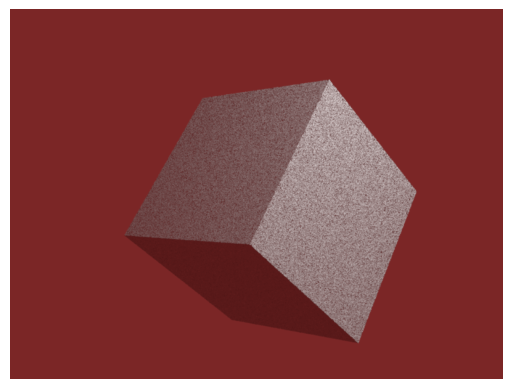

In [2]:
import mitsuba as mi
import matplotlib.pyplot as plt

mi.set_variant('scalar_rgb')

scene = mi.load_dict({
    "type": "scene",
    "integrator": {"type": "path"},

    "sensor": {
        "type": "perspective",
        "to_world": mi.ScalarTransform4f().look_at(
            origin=[0, 0, 40],
            target=[0, 0, 0],
            up=[0, 1, 0]
        ),
        "film": {
            "type": "hdrfilm",
            "width": 800,
            "height": 600,
            "pixel_format": "rgb"
        },
    },

    #  env light 
    "env": {
        "type": "constant",
        "radiance": {"type": "rgb", "value": [0.2, 0.02, 0.02]}
    },

    # Point light  
    "light": {
        "type": "point",
        "position": [20,20, 20],
        "intensity": {"type": "rgb", "value": [2050, 2050, 2050]}
    },

    "cube": {
        "type": "obj",
        "filename": "cube.obj",
        "to_world": (
            mi.ScalarTransform4f()
            .rotate([0, 1, 0], -45)   
            .rotate([1, 0, 0], -35) 
        ),
    },
})

img = mi.render(scene)
plt.imshow(mi.util.convert_to_bitmap(img))
plt.axis('off')
plt.show()


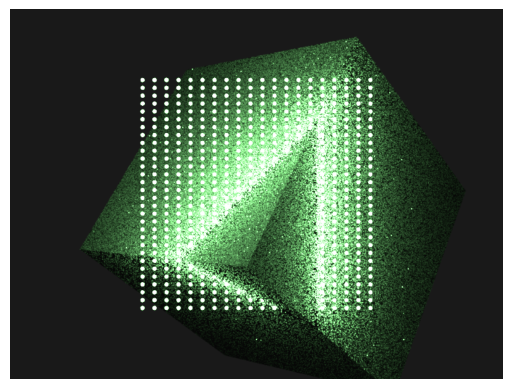

In [4]:
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np

mi.set_variant('scalar_rgb')

num_lights = 600

nx = 20 
ny = num_lights // nx  

x_positions = np.linspace(-4., 4, nx)
y_positions = np.linspace(-4, 4, ny)
z_position = 5  # on the open face

light_positions = []
for y in y_positions:
    for x in x_positions:
        light_positions.append([x, y, z_position])

emitters = {}
for i, pos in enumerate(light_positions):
    emitters[f"light_{i}"] = {
        "type": "sphere", 
        "center": pos,
        "radius": 0.05,  
        "emitter": {
            "type": "area",
            "radiance": {"type": "rgb", "value": [30, 100, 30]}  
        },
        # visible light render
        "bsdf": {
            "type": "diffuse",
            "reflectance": {"type": "rgb", "value": [1, 1, 1]}
        }
    }

cube = {
    "type": "obj",
    "filename": "cube.obj",
    "to_world": (
            mi.ScalarTransform4f()
            .rotate([0, 1, 0], -45)  
            .rotate([1, 0, 0], -35)
        ),
    "bsdf": {
        "type": "twosided",
        "bsdf": {
            "type": "diffuse",
            "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
        }
    }
}

scene_dict = {
    "type": "scene",
    "integrator": {"type": "path"},
    
    "sensor": {
        "type": "perspective",
        "to_world": mi.ScalarTransform4f().look_at(
            origin=[0, 0, 30],
            target=[0, 0, 0],
            up=[0, 1, 0]
        ),
        "film": {
            "type": "hdrfilm",
            "width": 800,
            "height": 600,
            "pixel_format": "rgb"
        },
    },
    
    "env": {
        "type": "constant",
        "radiance": {"type": "rgb", "value": [0.01, 0.01, 0.01]}
    },
    
    "cube": cube,
}

scene_dict.update(emitters)
scene = mi.load_dict(scene_dict)
img = mi.render(scene)
plt.imshow(mi.util.convert_to_bitmap(img))
plt.axis('off')
plt.show()


Total light emitters: 600


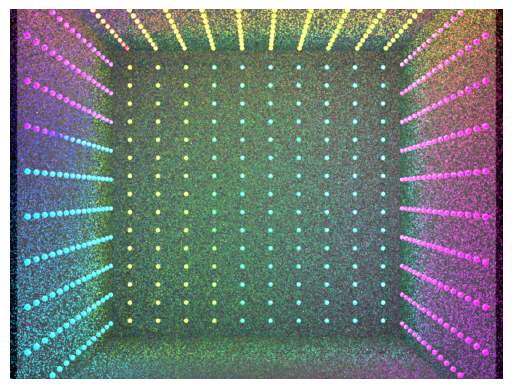

In [13]:
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
import colorsys

mi.set_variant('scalar_rgb')

def light_grid(face, n1, n2, const_val):
    positions = []
    if face == "top":
        # Top face
        xs = np.linspace(-4, 4, n1)
        zs = np.linspace(-4, 4, n2)
        for x in xs:
            for z in zs:
                positions.append([x, const_val, z])
    elif face == "back":
        # Back face
        xs = np.linspace(-4, 4, n1)
        ys = np.linspace(-4, 4, n2)
        for x in xs:
            for y in ys:
                positions.append([x, y, const_val])
    elif face == "left":
        # Left face
        ys = np.linspace(-4, 4, n1)
        zs = np.linspace(-4, 4, n2)
        for y in ys:
            for z in zs:
                positions.append([const_val, y, z])
    elif face == "right":
        # Right face
        ys = np.linspace(-4, 4, n1)
        zs = np.linspace(-4, 4, n2)
        for y in ys:
            for z in zs:
                positions.append([const_val, y, z])
    return positions

# 10 x 15 = 150 lights
top_pos   = light_grid("top",   10, 15,  4.5)   
back_pos  = light_grid("back",  10, 15, -4.5)  
left_pos  = light_grid("left",  10, 15, -4.5)  
right_pos = light_grid("right", 10, 15,  4.5)   

all_pos = top_pos + back_pos + left_pos + right_pos
print("Total light emitters:", len(all_pos))  

def rainbow(i, total):
    hue = i / total
    saturation = 1.0
    value = 1.0
    r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
    return [r * 50, g * 50, b * 50]

# Suppose you already generated 'all_positions' for 600 lights
# We'll just assume you have them in a list named all_positions.
# Build emitter definitions, each with a unique color.
emitters = {}
num_emitters = len(all_pos)
for i, pos in enumerate(all_pos):
    color = rainbow(i, num_emitters) 
    emitters[f"light_{i}"] = {
        "type": "sphere",
        "center": pos,
        "radius": 0.05,
        "emitter": {
            "type": "area",
            "radiance": {"type": "rgb", "value": color}
        },
        # Optional: a diffuse BSDF so you see the spheres themselves
        "bsdf": {
            "type": "diffuse",
            "reflectance": {"type": "rgb", "value": [1, 1, 1]}
        }
    }


scene_dict = {
    "type": "scene",
    "integrator": {"type": "path"},
    "sensor": {
        "type": "perspective",
        "to_world": mi.ScalarTransform4f().look_at(
            origin=[0, 0, 18],
            target=[0, 0, 0],
            up=[0, 1, 0]
        ),
        "film": {
            "type": "hdrfilm",
            "width": 800,
            "height": 600,
            "pixel_format": "rgb"
        },
    },
    "env": {
        "type": "constant",
        "radiance": {"type": "rgb", "value": [0.01, 0.01, 0.01]}
    },
    "cube-back":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([0, 0, -10])  
        , 
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    },

    "cube-top":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([0, 10, 0])  
        ,  
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    }, 
    "cube-left":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([10,0, 0]) 
        ,  
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    }, 
    "cube-right":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([-10, 0, 0]) 
        , 
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    }, 
    "cube-bottom":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([0, -10, 0])  
        , 
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    }
}

scene_dict.update(emitters)
scene = mi.load_dict(scene_dict)
img = mi.render(scene)
plt.imshow(mi.util.convert_to_bitmap(img))
plt.axis('off')
plt.show()


Total light emitters: 600


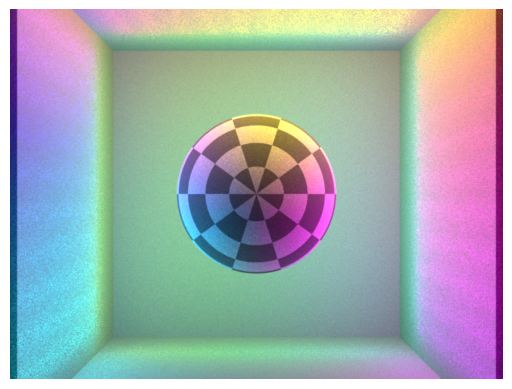

In [8]:
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
import colorsys

mi.set_variant('scalar_rgb')

def light_grid(face, n1, n2, const_val):
    positions = []
    if face == "top":
        # Top face
        xs = np.linspace(-4, 4, n1)
        zs = np.linspace(-4, 4, n2)
        for x in xs:
            for z in zs:
                positions.append([x, const_val, z])
    elif face == "back":
        # Back face
        xs = np.linspace(-4, 4, n1)
        ys = np.linspace(-4, 4, n2)
        for x in xs:
            for y in ys:
                positions.append([x, y, const_val])
    elif face == "left":
        # Left face
        ys = np.linspace(-4, 4, n1)
        zs = np.linspace(-4, 4, n2)
        for y in ys:
            for z in zs:
                positions.append([const_val, y, z])
    elif face == "right":
        # Right face
        ys = np.linspace(-4, 4, n1)
        zs = np.linspace(-4, 4, n2)
        for y in ys:
            for z in zs:
                positions.append([const_val, y, z])
    return positions

# 10 x 15 = 150 lights
top_pos   = light_grid("top",   10, 15,  4.5)   
back_pos  = light_grid("back",  10, 15, -4.5)  
left_pos  = light_grid("left",  10, 15, -4.5)  
right_pos = light_grid("right", 10, 15,  4.5)   

# 12 x 12 = 144 lights
# top_pos   = light_grid("top",   12, 12,  4.5)   
# back_pos  = light_grid("back",  12, 12, -4.5)  
# left_pos  = light_grid("left",  12, 12, -4.5)  
# right_pos = light_grid("right", 12, 12,  4.5)   

all_pos = top_pos + back_pos + left_pos + right_pos
print("Total light emitters:", len(all_pos))  

def rainbow(i, total):
    hue = i / total
    saturation = 1.0
    value = 1.0
    r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
    # return [r * 1.5, g * 1.5, b * 1.5]
    return [r, g, b]

# Suppose you already generated 'all_positions' for 600 lights
# We'll just assume you have them in a list named all_positions.
# Build emitter definitions, each with a unique color.
emitters = {}
num_emitters = len(all_pos)
for i, pos in enumerate(all_pos):
    color = rainbow(i, num_emitters) 
    emitters[f"light_{i}"] = {
        "type": "point",
        "position": pos,
        "intensity": {
            "type": "rgb",
            "value": color  # Use the rainbow function's RGB output
        }

        # "center": pos,
        # "radius": 0.05,
        # "emitter": {
        #     "type": "area",
        #     "radiance": {"type": "rgb", "value": color}
        # },
        # Optional: a diffuse BSDF so you see the spheres themselves
        # "bsdf": {
        #     "type": "diffuse",
        #     "reflectance": {"type": "rgb", "value": [1, 1, 1]}
        # }
    }
    


scene_dict = {
    "type": "scene",
    "integrator": {"type": "path"},
    "sensor": {
        "type": "perspective",
        "sampler": {
            "type": "independent",
            "sample_count": 512
        },
        "to_world": mi.ScalarTransform4f().look_at(
            origin=[0, 0, 18],
            target=[0, 0, 0],
            up=[0, 1, 0]
        ),
        "film": {
            "type": "hdrfilm",
            "width": 800,
            "height": 600,
            "pixel_format": "rgb"
        },
    },
    "env": {
        "type": "constant",
        "radiance": {"type": "rgb", "value": [0.01, 0.01, 0.01]}
    },
    "cube-back":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([0, 0, -10])  
        , 
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    },

    "cube-top":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([0, 10, 0])  
        ,  
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    }, 
    "cube-left":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([10,0, 0]) 
        ,  
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    }, 
    "cube-right":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([-10, 0, 0]) 
        , 
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    }, 
    "cube-bottom":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([0, -10, 0])  
        , 
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    },
    "center_sphere": {
        "type": "sphere",
        "to_world": mi.ScalarTransform4f().translate([0, 0, 0]).scale(2),  # Adjust position & size
        "bsdf": {
            "type": "diffuse",
            # "reflectance": {
            #     "type": "rgb",
            #     "value": [0.5, 0.5, 0.5]
            # }
            "reflectance": {
                "type": "checkerboard",
                "color0": {"type": "rgb", "value": [0.8, 0.8, 0.8]},
                "color1": {"type": "rgb", "value": [0.2, 0.2, 0.2]},
                "to_uv": mi.Transform4f().scale([5, 5, 5])


            }
        }
    }
}

scene_dict.update(emitters)
scene = mi.load_dict(scene_dict)
img = mi.render(scene)
plt.imshow(mi.util.convert_to_bitmap(img))
plt.axis('off')
plt.show()


In [ ]:
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
import colorsys

mi.set_variant('scalar_rgb')

def light_grid(face, n1, n2, const_val):
    positions = []
    if face == "top":
        # Top face
        xs = np.linspace(-4, 4, n1)
        zs = np.linspace(-4, 4, n2)
        for x in xs:
            for z in zs:
                positions.append([x, const_val, z])
    elif face == "back":
        # Back face
        xs = np.linspace(-4, 4, n1)
        ys = np.linspace(-4, 4, n2)
        for x in xs:
            for y in ys:
                positions.append([x, y, const_val])
    elif face == "left":
        # Left face
        ys = np.linspace(-4, 4, n1)
        zs = np.linspace(-4, 4, n2)
        for y in ys:
            for z in zs:
                positions.append([const_val, y, z])
    elif face == "right":
        # Right face
        ys = np.linspace(-4, 4, n1)
        zs = np.linspace(-4, 4, n2)
        for y in ys:
            for z in zs:
                positions.append([const_val, y, z])
    return positions

# 10 x 15 = 150 lights
# top_pos   = light_grid("top",   10, 15,  4.5)   
# back_pos  = light_grid("back",  10, 15, -4.5)  
# left_pos  = light_grid("left",  10, 15, -4.5)  
# right_pos = light_grid("right", 10, 15,  4.5)   

# 12 x 12 = 144 lights
top_pos   = light_grid("top",   12, 12,  4.5)   
back_pos  = light_grid("back",  12, 12, -4.5)  
left_pos  = light_grid("left",  12, 12, -4.5)  
right_pos = light_grid("right", 12, 12,  4.5)   

all_pos = top_pos + back_pos + left_pos + right_pos
print("Total light emitters:", len(all_pos))  


# Suppose you already generated 'all_positions' for 600 lights
# We'll just assume you have them in a list named all_positions.
# Build emitter definitions, each with a unique color.
emitters = {}
num_emitters = len(all_pos)
for i, pos in enumerate(all_pos):
    color = [1, 1, 1]
    emitters[f"light_{i}"] = {
        "type": "point",
        "position": pos,
        "intensity": {
            "type": "rgb",
            "value": color  # Use the rainbow function's RGB output
        }

#         # "center": pos,
#         # "radius": 0.05,
#         # "emitter": {
#         #     "type": "area",
#         #     "radiance": {"type": "rgb", "value": color}
#         # },
#         # Optional: a diffuse BSDF so you see the spheres themselves
#         # "bsdf": {
#         #     "type": "diffuse",
#         #     "reflectance": {"type": "rgb", "value": [1, 1, 1]}
#         # }
}
    

hdri = mi.Bitmap('../night_hdri.exr').convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32)
scene_dict = {
    "type": "scene",
    "integrator": {"type": "path"},
    "sensor": {
        "type": "perspective",
        "sampler": {
            "type": "independent",
            "sample_count": 512
        },
        "to_world": mi.ScalarTransform4f().look_at(
            origin=[0, 0, 18],
            target=[0, 0, 0],
            up=[0, 1, 0]
        ),
        "film": {
            "type": "hdrfilm",
            "width": 800,
            "height": 600,
            "pixel_format": "rgb"
        },
    },
    
    "env": {
        "type": "constant",
        "radiance": {"type": "rgb", "value": [0.01, 0.01, 0.01]}
    },
    "env": {
        "type": "envmap",
        # "filename": "../sample_hdri.exr",
        "bitmap": hdri,

    },
    "cube-back":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([0, 0, -10])  
        , 
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    },

    "cube-top":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([0, 10, 0])  
        ,  
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    }, 
    "cube-left":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([10,0, 0]) 
        ,  
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    }, 
    "cube-right":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([-10, 0, 0]) 
        , 
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    }, 
    "cube-bottom":{
        "type": "obj",
        "filename": "cube.obj",
        "to_world": mi.ScalarTransform4f()
            .translate([0, -10, 0])  
        , 
        "bsdf": {
            "type": "twosided",
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }
    },
    "center_sphere": {
        "type": "sphere",
        "to_world": mi.ScalarTransform4f().translate([0, 0, 0]).scale(2),  # Adjust position & size
        "bsdf": {
            "type": "diffuse",
            # "reflectance": {
            #     "type": "rgb",
            #     "value": [0.5, 0.5, 0.5]
            # }
            "reflectance": {
                "type": "checkerboard",
                "color0": {"type": "rgb", "value": [0.8, 0.8, 0.8]},
                "color1": {"type": "rgb", "value": [0.2, 0.2, 0.2]},
                "to_uv": mi.Transform4f().scale([5, 5, 5])


            }
        }
    }
}

# scene_dict.update(emitters)
scene = mi.load_dict(scene_dict)
img = mi.render(scene)
plt.imshow(mi.util.convert_to_bitmap(img))
plt.axis('off')
plt.show()


Total light emitters: 576
